# Edoardo Antonaci 1234431

# Homework1 : Classification task

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [4]:
mnist = fetch_openml('mnist_784', cache=True)

X = mnist.data.astype('float32')
Y = mnist.target.astype('int64')

#Normalization of the value between 0 and 1
X /= 255.0

In [5]:
X=torch.from_numpy(np.array(X))

X=X.to(dtype = torch.float32)

In [6]:
#Dataset for Cnn model
X = X.reshape(-1, 1, 28, 28)

#Train - test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([52500, 1, 28, 28]),
 (52500,),
 torch.Size([17500, 1, 28, 28]),
 (17500,))

5

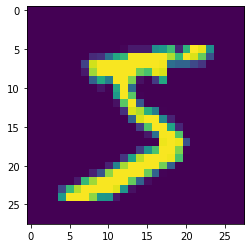

In [7]:
#example
plt.imshow(X_train[0][0])
y_train[0]

In [8]:

from skorch import NeuralNetClassifier

import torch.nn.functional as F
class Cnn(nn.Module):
    def __init__(self, dropout=0.5,conv1=32,init_weight_fc=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, conv1, kernel_size=5)
        self.conv1_drop = nn.Dropout2d(p=dropout)
        
        flatten_dim = conv1*12*12# number channels * width * height
        
        self.fc1 = nn.Linear(flatten_dim,10) 
  
        self.fc1_drop = nn.Dropout(p=dropout)
        
        if init_weight_fc=="N":
          torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0/self.fc1.in_features)
          self.fc2.bias.data.fill_(0.0)
         
          
        if init_weight_fc=="U" :
          torch.nn.init.uniform_(self.fc1.weight,a=0.0,b=1.0)
          

    def forward(self, x):
        
        x = torch.relu(F.max_pool2d( self.conv1(x) , 2) )
  
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x= torch.relu(self.fc1_drop( self.fc1(x) ) )
        
        x= torch.softmax( x,dim= -1 )         
        
        return x
  

In [9]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [10]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

#Early Stopping
from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)

net = NeuralNetClassifier(
    module=Cnn,
    module__conv1=10,
    device=device,
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-4, #L2 norm
    criterion=nn.CrossEntropyLoss,
    callbacks = [my_early],
)

In [11]:
from sklearn.model_selection import GridSearchCV
params = {
    'module__conv1': [3,5,8,10],
    'max_epochs': [1500],
    'optimizer__lr':[0.01, 0.001,0.0001],
    'optimizer__weight_decay':[1e-2,1e-3,1e-4,0] #L2 norm,
}


gs = GridSearchCV(net, params, refit=True, cv=3, scoring="accuracy",verbose=10)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)
net=gs.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] max_epochs=1500, module__conv1=3, optimizer__lr=0.01, optimizer__weight_decay=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9964       0.8537        1.7872  0.9263
      2        1.9607       0.8961        1.7702  0.7246
      3        1.9576       0.8890        1.7918  0.6617
      4        1.9564       0.8940        1.7545  0.6615
      5        1.9532       0.8973        1.7667  0.6700
      6        1.9583       0.8723        1.7812  0.6626
      7        1.9583       0.8859        1.7859  0.6615
      8        1.9596       0.9019        1.7604  0.6614
      9        1.9591       0.8907        1.7817  0.7028
     10        1.9543       0.9101        1.7682  0.6555
     11        1.9569       0.8821        1.7749  0.6735
     12        1.9584       0.8783        1.7942  0.6368
     13        1.9576       0.9027        1.7695  0.6516
     14        1.9553       0.8843        1.7534  0.6656
     15        1.9566       0.8949        1.7807  0.6793
     16        1.9568       0.9

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0812       0.8087        1.7948  0.7108
      2        2.0025       0.8037        1.8013  0.6821
      3        1.9961       0.7949        1.7901  0.6851
      4        1.9894       0.8046        1.8158  0.6703
      5        1.9910       0.7929        1.8021  0.6666
      6        1.9912       0.8039        1.8262  0.6704
      7        1.9914       0.8030        1.8143  0.6699
      8        1.9941       0.8011        1.8447  0.6663
      9        1.9894       0.7883        1.8062  0.6898
     10        1.9929       0.8130        1.7966  0.6920
     11        1.9874       0.7977        1.8109  0.6433
     12        1.9896       0.8079        1.7932  0.6627
     13        1.9933       0.8171        1.7853  0.6902
     14        1.9940       0.7797        1.8016  0.6898
     15        1.9787       0.8734        1.7650  0.6780
     16        1.9630       0.8

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.4s remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0754       0.7951        1.8282  0.6781
      2        1.9954       0.7967        1.8151  0.6557
      3        1.9731       0.8527        1.7627  0.6515
      4        1.9635       0.9039        1.7535  0.6572
      5        1.9646       0.8597        1.7976  0.6601
      6        1.9649       0.8983        1.7670  0.7098
      7        1.9640       0.8900        1.7716  0.6777
      8        1.9568       0.8670        1.7979  0.6792
      9        1.9625       0.8740        1.7745  0.6730
     10        1.9644       0.8921        1.7660  0.6727
     11        1.9646       0.8819        1.7627  0.6804
     12        1.9663       0.9044        1.7700  0.6733
     13        1.9608       0.8616        1.7911  0.6482
Stopping since valid_loss has not improved in the last 10 epochs.
[CV]  max_epochs=1500, module__conv1=3, optimizer__lr=0.01, optimizer__weight_d

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.2s remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0884       0.6733        1.8191  0.6717
      2        2.0181       0.7741        1.7498  0.6742
      3        1.9859       0.8459        1.6783  0.6648
      4        1.9630       0.8594        1.6530  0.6818
      5        1.9579       0.8553        1.6824  0.6560
      6        1.9561       0.8659        1.6639  0.6504
      7        1.9549       0.8594        1.6806  0.6336
      8        1.9537       0.8611        1.6721  0.6661
      9        1.9554       0.8654        1.6777  0.6654
     10        1.9568       0.8669        1.6619  0.6824
     11        1.9536       0.8646        1.6714  0.6632
     12        1.9548       0.8587        1.6711  0.6708
     13        1.9351       0.9293        1.6173  0.6945
     14        1.9230       0.9467        1.5958  0.6650
     15        1.9221       0.9453        1.5964  0.6741
     16        1.9218       0.9

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0499       0.8207        1.7108  0.6632
      2        1.9754       0.8286        1.6895  0.6426
      3        1.9756       0.8344        1.6861  0.6679
      4        1.9403       0.9374        1.6089  0.6591
      5        1.9265       0.9406        1.6037  0.6427
      6        1.9238       0.9486        1.6023  0.6693
      7        1.9219       0.9493        1.6045  0.7308
      8        1.9205       0.9527        1.6090  0.6978
      9        1.9222       0.9511        1.6081  0.6595
     10        1.9146       0.9561        1.5996  0.6605
     11        1.9179       0.9553        1.6138  0.6757
     12        1.9188       0.9554        1.5997  0.6908
     13        1.9184       0.9540        1.5978  0.6905
     14        1.9154       0.9537        1.6038  0.6865
     15        1.9187       0.9530        1.6062  0.7014
     16        1.9173       0.9

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0500       0.7243        1.7862  0.6721
      2        1.9871       0.8617        1.6740  0.6717
      3        1.9569       0.8597        1.6820  0.6766
      4        1.9532       0.8660        1.6639  0.7112
      5        1.9556       0.8737        1.6848  0.6602
      6        1.9560       0.8666        1.6657  0.6771
      7        1.9515       0.8716        1.6515  0.6558
      8        1.9496       0.8690        1.6701  0.6526
      9        1.9533       0.8689        1.6577  0.7142
     10        1.9373       0.9447        1.5909  0.6882
     11        1.9164       0.9504        1.5944  0.6578
     12        1.9202       0.9523        1.6033  0.6602
     13        1.9184       0.9453        1.6010  0.6724
     14        1.9181       0.9556        1.5999  0.6517
     15        1.9206       0.9460        1.5948  0.6558
     16        1.9151       0.9

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2384       0.2879        2.1599  0.6776
      2        2.2287       0.2936        2.1547  0.6858
      3        2.2255       0.2931        2.1558  0.6760
      4        2.2260       0.2943        2.1104  0.6655
      5        2.1371       0.4764        1.9270  0.6951
      6        2.1040       0.5757        1.8449  0.6687
      7        2.0688       0.5779        1.8470  0.6575
      8        2.0644       0.5784        1.8441  0.6617
      9        2.0455       0.6891        1.7575  0.6848
     10        2.0197       0.6937        1.7475  0.6955
     11        2.0174       0.6947        1.7536  0.6674
     12        2.0196       0.6877        1.7612  0.6637
     13        2.0190       0.6946        1.7521  0.6710
     14        2.0192       0.6929        1.7638  0.6686
     15        2.0214       0.6873        1.7636  0.6819
     16        2.0153       0.6

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1307       0.4821        1.9357  0.6685
      2        2.1151       0.4864        1.9230  0.6623
      3        2.0872       0.5741        1.8473  0.6524
      4        2.0663       0.5810        1.8405  0.6889
      5        2.0694       0.5827        1.8354  0.6738
      6        2.0666       0.5827        1.8370  0.6999
      7        2.0650       0.5819        1.8353  0.6580
      8        2.0675       0.5817        1.8395  0.6871
      9        2.0639       0.5834        1.8344  0.6622
     10        2.0049       0.7737        1.6910  0.7084
     11        1.9816       0.8516        1.6250  0.7004
     12        1.9507       0.8629        1.6081  0.7158
     13        1.9467       0.8613        1.6114  0.7000
     14        1.9449       0.8664        1.6109  0.7003
     15        1.9495       0.8689        1.6010  0.6819
     16        1.9427       0.8

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1874       0.3087        2.0628  0.6797
      2        2.1782       0.3099        2.0561  0.6629
      3        2.1781       0.3110        2.0527  0.6809
      4        2.1766       0.3100        2.0528  0.6887
      5        2.1772       0.3971        1.9954  0.6728
      6        2.1315       0.4981        1.9023  0.6718
      7        2.0973       0.5003        1.9000  0.6546
      8        2.0832       0.5803        1.8379  0.6377
      9        2.0673       0.5907        1.8266  0.6605
     10        2.0573       0.6667        1.7734  0.6700
     11        2.0295       0.6740        1.7592  0.6585
     12        2.0017       0.7641        1.6854  0.6604
     13        1.9742       0.8586        1.6031  0.6565
     14        1.9473       0.8639        1.6034  0.6397
     15        1.9457       0.8666        1.5977  0.6485
     16        1.9428       0.8

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s


Output streaming troncato alle ultime 5000 righe.
     40        2.1063       0.5820        1.9408  0.6508
     41        2.1071       0.5827        1.9398  0.6607
     42        2.1055       0.5833        1.9398  0.6515
     43        2.1058       0.5841        1.9400  0.6706
     44        2.1089       0.5831        1.9377  0.6470
     45        2.1061       0.5853        1.9396  0.6467
     46        2.1070       0.5850        1.9399  0.6655
     47        2.1057       0.5840        1.9350  0.6487
     48        2.1065       0.5851        1.9372  0.6410
     49        2.1038       0.5850        1.9360  0.6732
     50        2.1012       0.5863        1.9348  0.6511
     51        2.0749       0.6727        1.8772  0.6704
     52        2.0677       0.6719        1.8670  0.6499
     53        2.0667       0.6744        1.8644  0.6602
     54        2.0664       0.6753        1.8635  0.6586
     55        2.0664       0.6759        1.8623  0.6728
     56        2.0660       0.6754    

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 114.0min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1736       0.3877        2.0283  1.0111
      2        2.1316       0.4792        1.9554  0.9913
      3        2.1125       0.4806        1.9522  0.9701
      4        2.1092       0.4842        1.9397  1.0219
      5        2.1078       0.4852        1.9404  0.9956
      6        2.1050       0.4838        1.9404  0.9692
      7        2.1033       0.4857        1.9426  0.9883
      8        2.1035       0.4883        1.9328  0.9912
      9        2.1033       0.4890        1.9322  0.9928
     10        2.1030       0.4903        1.9260  1.0261
     11        2.1002       0.4900        1.9261  1.0058
     12        2.0792       0.5810        1.8572  0.9898
     13        2.0632       0.5828        1.8518  0.9779
     14        2.0622       0.5841        1.8514  0.9871
     15        2.0634       0.5849        1.8434  0.9836
     16        2.0636       0.5

In [12]:
net.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: conv1.
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1431       0.4746        1.9737  1.0352
      2        2.0892       0.5688        1.8850  1.0044
      3        2.0786       0.5716        1.8737  1.0039
      4        2.0762       0.5738        1.8701  0.9765
      5        2.0768       0.5731        1.8678  0.9767
      6        2.0332       0.6848        1.7949  1.0090
      7        2.0260       0.6860        1.7785  0.9988
      8        2.0263       0.6879        1.7727  0.9958
      9        2.0190       0.6911        1.7755  0.9817
     10        2.0207       0.6928        1.7704  0.9918
     11        2.0168       0.6940        1.7688  0.9895
     12        2.0130       0.6950        1.7630  0.9861
     13        2.0176       0.6970  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cnn(
    (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (conv1_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=720, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

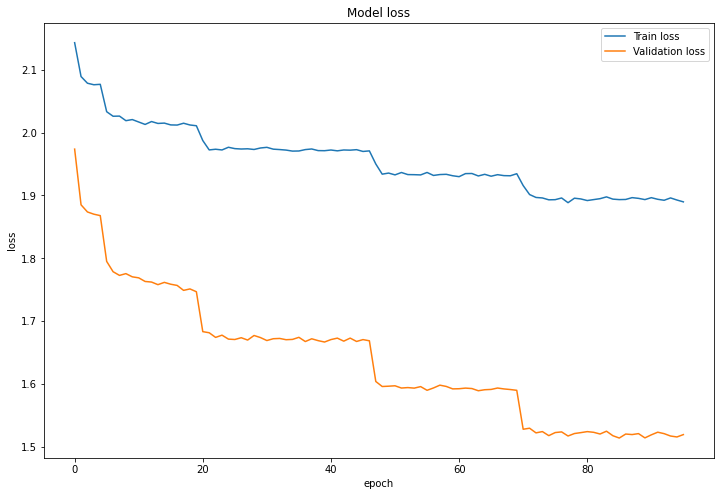

In [13]:
import datetime
save_name="Classification_"

# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig(save_name+"_Losses", dpi=400)
plt.show()

In [14]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(test_acc)

0.9806857142857143


In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd,
                          save_path='homework_NN_DL_edoardo/'):
    

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig(save_path+"ConfMatrix.png", dpi=400)
    plt.tight_layout()

Train Loss:	 1.89
Val Acc:	 0.977
Test Acc:	 0.981


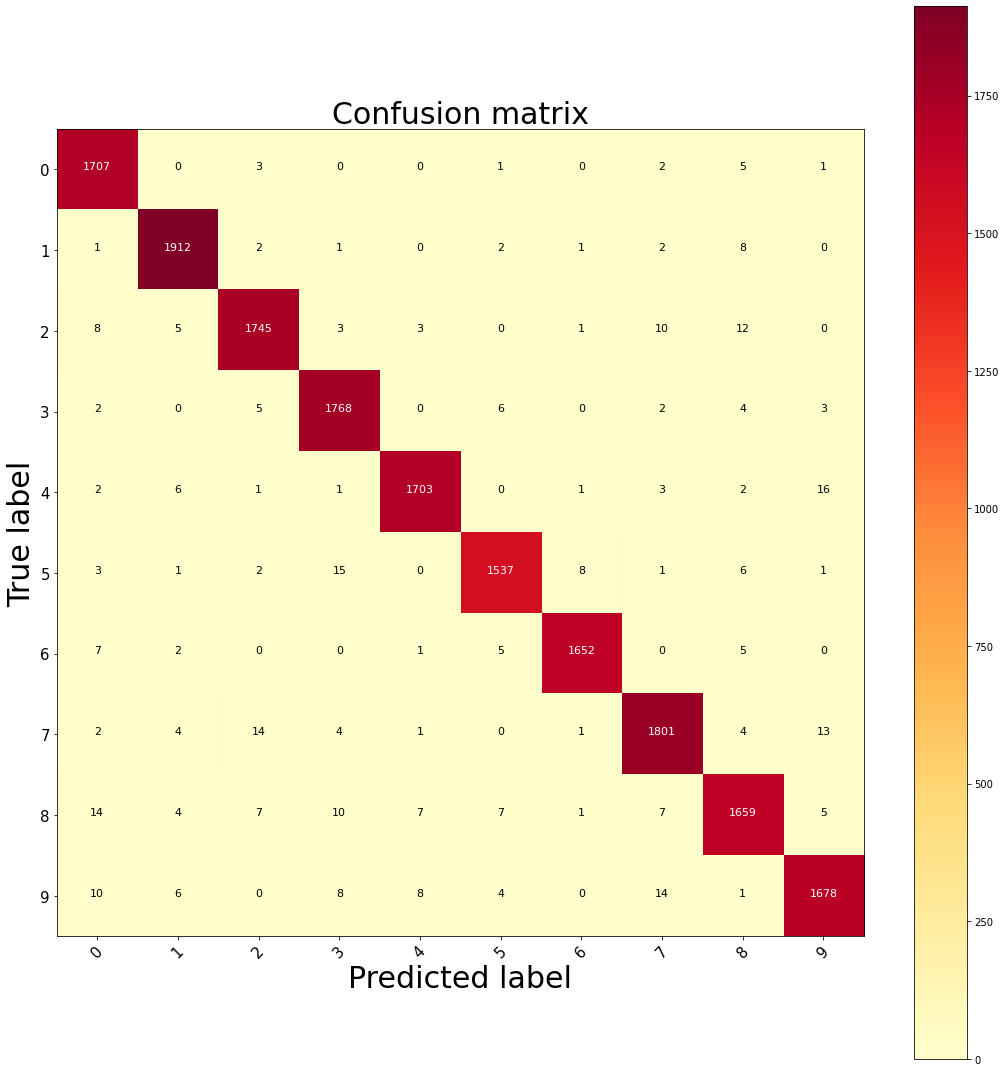

In [16]:
#Accuracy
val_acc=history[:, 'valid_acc'][-1]
val_loss=history[:, 'valid_loss'][-1]
train_loss=history[:, 'train_loss'][-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Acc:\t",round(val_acc,3))
print("Test Acc:\t",round(float(test_acc),3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories, normalize=False,save_path=save_name)

In [17]:
#Access network parameters
my_best_net = net.module_

# Conv 1 layer
c1_w = my_best_net.conv1.weight.data.cpu().numpy()
c1_b = my_best_net.conv1.bias.data.cpu().numpy()


#Full connected hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()



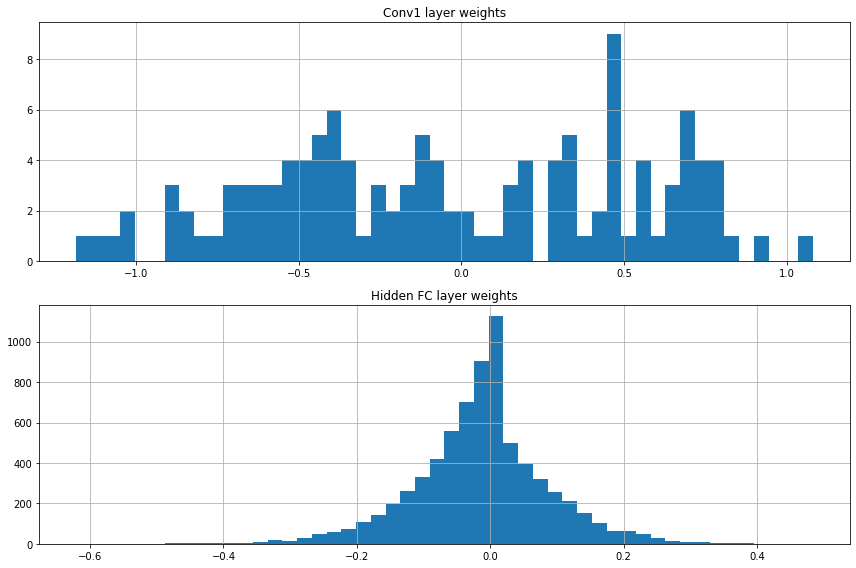

In [18]:
# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('Conv1 layer weights')
axs[1].hist(h1_w.flatten(), 50)
axs[1].set_title('Hidden FC layer weights')


[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig(save_name+"_Weights-histogram", dpi=400)
plt.show()

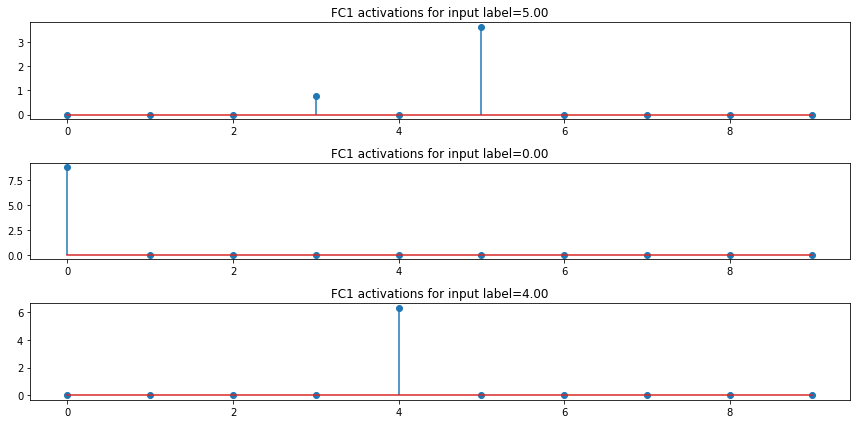

In [19]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc1.register_forward_hook(get_activation)


### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = X_train[0].clone().detach().unsqueeze(0).to(device)
    y1 = net(x1)
    z1 = activation
    x2 = X_train[1].clone().detach().unsqueeze(0).to(device)
    y2 = net(x2)
    z2 = activation
    x3 = X_train[2].clone().detach().unsqueeze(0).to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('FC1 activations for input label=%.2f' % y_train[0])
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('FC1 activations for input label=%.2f' % y_train[1])
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('FC1 activations for input label=%.2f' % y_train[2])
plt.tight_layout()
plt.savefig(save_name+"_Activations", dpi=400)
plt.show()

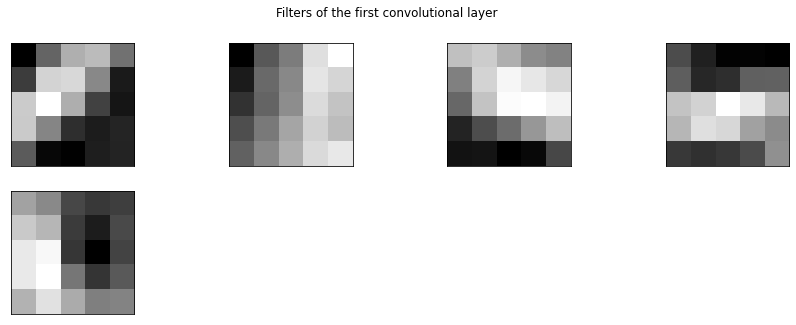

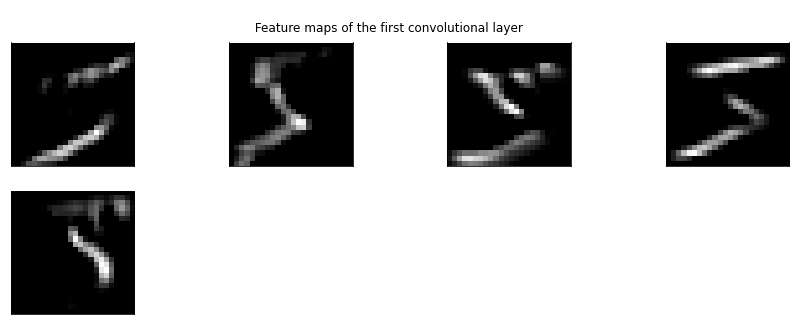

In [23]:
#first we collect the filters of the first convolutional layer 
#these are 5 as the number of neurons of the layer
filters_1 = my_best_net.conv1.weight
filters_1 = torch.squeeze(filters_1,1)

filters_1  = filters_1.cpu().detach().numpy()

features = []
input = X_train[0].clone().detach().unsqueeze(0).to(device)

#define a funcion that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = my_best_net.conv1.register_forward_hook(get_features_map)
my_best_net.eval()
with torch.no_grad():
    out = my_best_net(input)
### Remove hook
hook_handle.remove()

#plot the filters and their relative feature maps for the first sample of the test_dataset
plt.figure(figsize=(15,5))
for i in range(1, 6):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filters_1[i-1], cmap='gray')
plt.suptitle('Filters of the first convolutional layer') 
plt.savefig(save_name+"_Filters", dpi=400)

act = nn.ReLU()

plt.figure(figsize=(15,5))
for i in range(1, 6):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the first convolutional layer')
plt.savefig(save_name+"_FeatureMaps", dpi=400)
plt.show()